## Tensorflow Probability - Estimation (aka Learning)  
### Day 5/100 Days of TensorFlow Probability  

Today, we are going to extend our journey from Day 3 where we explored the use of the `log_prob()` method and applied this to a simple anomaly detection case. In doing so, we manually defined a baseline distribution and used this baseline to score our observed data.  

Ideally though, we should be able to learn a baseline distribution from historical data and use this for future data. This is what we will explore in this notebook.

Let's quicly recap where we left off in Day 3. Below is our "baseline model", our observed data and the anomaly scores that we finished with:

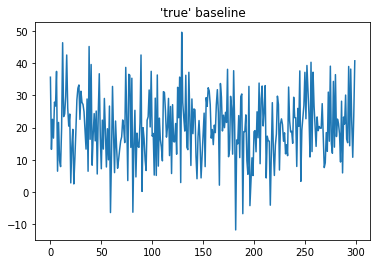

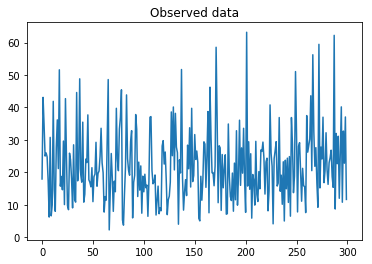

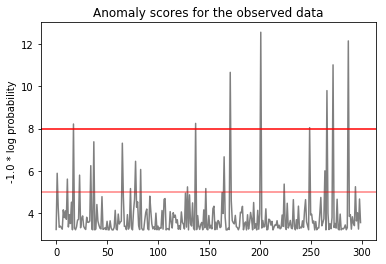

In [11]:
import collections
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

import matplotlib.pyplot as plt

from __future__ import print_function


np.random.seed(1965)

# Baseline model
baseline = tfd.Normal(loc = 20, scale = 10)
plt.plot(range(0, 300), baseline.sample(300).numpy())
plt.title("'true' baseline")
plt.show()


# Observed data (simulated)
rv_chi2 = tfd.Chi2(df = 8)
data = rv_chi2.sample(300)
data = tf.cast(data.numpy()*3.0, tf.float32)
plt.plot(range(0,300), data)
plt.title("Observed data")
plt.show()


# Anomaly scores
anomaly_scores = -1.0 * baseline.log_prob(data)
plt.plot(range(0, 300), anomaly_scores, color='grey')
plt.axhline(y = 5, color='red', alpha=0.5)
plt.axhline(y = 8, color='red')
plt.ylabel("-1.0 * log probability")
plt.title("Anomaly scores for the observed data")
plt.show()

This works reasonably well. The only drawback here, is that the we manually "guessed" the parameters for the baseline model. What we really want to do, is to estimate the mean and standard deviation from the data itself. For example, we might take the first 150 observations as our training set and leave the second half aside for testing. Let's give this a go.

### "Learning" in Tensorflow Probability  

For me, this is where things get really, really obscure when it comes to tensorflow probability. IMO (let me really epmhasise this, in *my opinion*) tfp's code is really challenging. It seems to take a lot of code and it isn't particularly intuitive to me.  

[Here is a really nice example](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/HLM_TFP_R_Stan.ipynb) which compares the estimates from a hierarchical model built using R's lme4, Stan and tensorflow probability. Have a quick read of the article and you'll see what I mean.  

**lme4** has a nice, elegant formulaic-approach which is very typical of R:

```
# https://github.com/stan-dev/example-models/wiki/ARM-Models-Sorted-by-Chapter
radon.model <- lmer(log_radon ~ 1 + floor  + (0 + log_uranium_ppm | county), data = data)
```

**stan** has similar abstractions:  

```
fit <- stan_lmer(log_radon ~ 1 + floor  + (0 + log_uranium_ppm | county), data = data)
```

But even if you were to write this in raw Stan, stancode has a very nice elegant logic to it:

```
data {
  // your data does here
}
parameters {
  // define what you want to estimate here
}
model {
  // write out your model
}
```

And in contrast, the **tfp** example code given crosses over numerous code chunks, includes manually defining the joint probability function, the loss function and all sorts of craziness (haha - it's only crazy because I don't understand it yet).  

I am days (or maybe weeks) away from being able to write anything like this myself. But thankfully, tfp does provide some abstractions which makes this easier. In particular, we will look at the [generalised linear model](https://www.tensorflow.org/probability/api_docs/python/tfp/glm/fit) and the [tensorflow probabilistic layers](https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf) abstractions.

This is the only [GLM Notebook](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Generalized_Linear_Models.ipynb#scrollTo=KEVnTz2hh9RN) I have been able to find so sar.


### TFP GLM  

Let's begin with the GLM interface. Although I know that my data isn't truly Gaussian (it's simulated from a $\chi^2(df=8)$), I am going to stick with the idea of approximating the data with a Gaussian. The goal here then, is to learn the mean and standard deviation of this Gaussian.

The `tfp.glm.fit(X, y, model)` syntax is pretty self-explanatory. We supply our `(x, y)` pairs and we define a distribution-family in just the same way you would with R's `glm()` function.

A couple of notes below:

  - our model_matrix is really an intercept-only model. Thus, to create our "features" (`xtrain, xtest`) we have concatenated a bias term (`1.0`) to the index (`1..150`).   
  - My expectation is that the bias term will hold the intercept and the estimate should be zero (or very close to it) for the index  
  - By deafult, `tfp.glm.Normal` will estimate the mean, but not the variance. We could assume the empirical variance and use this, but instead I will scale and center the data so that it has unit-variance. Then, we need only estimate the mean (i.e. the intercept term). Our predictions will then have unit-variance, which will scale up when we back transform the predictions to the original scale.


In [126]:
# create our features as a matrix: [bias, index]
xtrain = xtest = np.vstack([[1.0, x] for x in range(150)])

# center and scale our data
mu, sigma = [np.mean(data[:150]), np.std(data[:150])]
ytrain, ytest = [(data[:150] - mu)/sigma, (data[150:] - mu)/sigma]

# model the mean
weights, yhat, is_converged, num_iter = tfp.glm.fit(
  model_matrix = tf.cast(xtrain, "float32"),
  response = ytrain,
  model = tfp.glm.Normal()
)

print("Empirical mean: {:.3f}, Centered mean: {:.3f}".format(mu, np.mean(ytrain)))
print("Coefficients: intercept = {:.3f}, beta = {:.3f}".format(weights.numpy()[0], weights.numpy()[1]))

Empirical mean: 21.541, Centered mean: 0.000
Coefficients: intercept = 0.089, beta = -0.001


These results look quite positive. The intercept term is very close to zero, which is what we would expect given than our data has been centered. More importantly, the x-index of our data has no effect. So far so good.

We can also quickly check the residuals and hope that these are normally distributed: $\epsilon \sim N(0, 1)$:

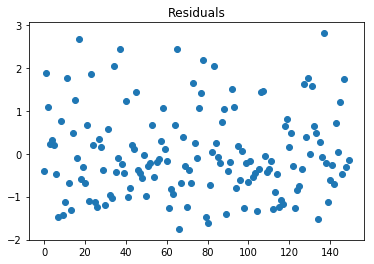

In [122]:
plt.scatter(range(0, 150), (ytrain - yhat)/sigma)
plt.title("Residuals")
plt.show()

And again, these look pretty good.

### Applying these estimates to anomaly scoring  

Let's use these learned values to test for anomalies again. We've actually already centered and scaled our test set using the emiprical mean and standard deviation of the training set. So we don't need to do this here. If, our training set is a fair representation of the test set, then our test set should follow the same distribution as our training distribution (i.e. a standard normal).

Below, I am going to plot our original anomaly scores (which were assessed for the entire dataset). I will also plot "new" anomaly scores for both our training set and our test set. In this way, we can compare the original scores with these new ones directly.

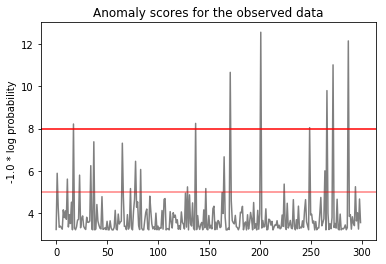

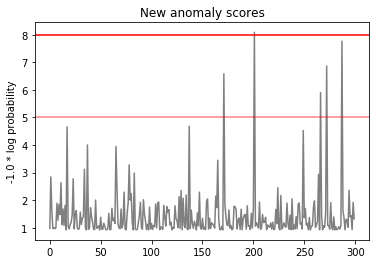

In [135]:
# our original anomaly scores
plt.plot(range(0, 300), anomaly_scores, color='grey')
plt.axhline(y = 5, color='red', alpha=0.5)
plt.axhline(y = 8, color='red')
plt.ylabel("-1.0 * log probability")
plt.title("Anomaly scores for the observed data")
plt.show()

# our new anomaly scores
transformed_score = -1.0 * tfd.Normal(loc = 0., scale = 1.).log_prob(np.concatenate([ytrain, ytest]))
plt.plot(range(0, 300), transformed_score, color='grey')
plt.axhline(y = 5, color='red', alpha=0.5)
plt.axhline(y = 8, color='red')
plt.ylabel("-1.0 * log probability")
plt.title("New anomaly scores")
plt.show()

Overall, this looks perfectly sensible. We've got fewer anomalies in our second method. This is a result of a more accurate mean and variance than my original guesses.

To be fair, this isn't particularly compelling. Because our data really was simulated from an intercept-only model, all of this effort reduces to a very naive model of the mean and variance. This is simplified even further since we centered and scaled the data, meaning our "model" is really just a standard normal. Not that impressive :) But, it is good that this worked as expected. I'd have been very alarmed if the machine had learned anything different!

Just as a bit of a sanity check, let's simulate *new data* from our "model". This new data should look a lot like our historical data:

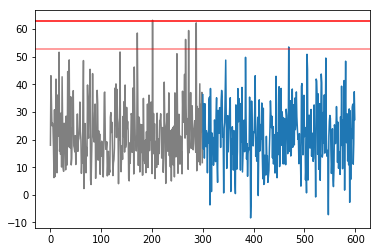

In [148]:
generative_model = tfd.Normal(loc = 0., scale = 1.)
new_data = generative_model.sample(300) * sigma + mu

plt.plot(range(0, 300), data, color='grey')
plt.plot(range(300, 600), new_data)
plt.axhline(y = 2.85 * sigma + mu, color='red', alpha=0.5)
plt.axhline(y = 3.75 * sigma + mu, color='red')
plt.show()

Our simulated data looks perfectly reasonable. I've also included our "anomaly thresholds" as a reference point.  


### Dialing this up a notch or two...  

Ok, so far, so good. But nothing exciting. Let's ramp this up a little bit and experiment with some more interesting data. I'm am still going to work with simulated data, so that we *will know* what the true parameters are, and we can see how well these are recovered. But, the data will be a little more interesting. Let's have a look at it:

[[-5.11390561]
 [ 3.05345141]
 [ 5.09774664]]


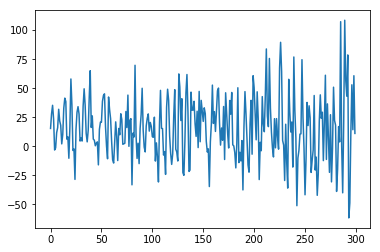

In [307]:
np.random.seed(1704)

# simulate 300 observations which follow a rough seasonal pattern
N = 300
X = np.transpose(
    np.matrix([
        np.ones(N),                                      # intercept term 
        np.random.normal(7, 3, N),                       # a feature, centered about 5
        np.random.normal(3, 1.5, N) * np.sin(range(N)),  # a seasonal feature
    ]))

# define our "groung truth"
# these are the parameters that we will attempt to recover
betas = np.matrix([
    np.random.normal(-5, 2, N),                          # the intercept, approx. -3
    np.random.normal(3, 0.8, N),                         # the effect for the first feature
    np.random.normal(5, 2, N),                           # the seasonal effect, which will be tough as it will nearly cross 0
])
ground_truth_betas = np.mean(betas, axis=1)
print(ground_truth_betas)

# create a response variable, which is a function of our Xs + noise
y = np.mean(np.matmul(X, betas), axis=1)
y += np.random.normal(0, [1.75*np.sqrt(x) for x in range(N)], N)[:,np.newaxis]
y = tf.convert_to_tensor(y.reshape(300,)).numpy()[0]     # had to play around with the shape of this a lot. 
                                                         # Still don't quite understand this, but it passes into gim.fit now

plt.plot(range(N), y)
plt.show()

This little dataset is a lot more interesting! Let's go through a couple of iterations on this one. First, let's model this exactly like we did previously - with an intercept only model:

In [308]:
weights, yhat, is_converged, num_iter = tfp.glm.fit(
  model_matrix = np.vstack([[1.0, x] for x in range(N)]),
  response = y,
  model = tfp.glm.Normal()
)
print(weights)

print("Empirical mean = {:.3f}, Estimated mean = {:.3f}".format(
    np.mean(y),
    weights.numpy()[0]
))

tf.Tensor([ 1.61882926e+01 -3.76206712e-03], shape=(2,), dtype=float64)
Empirical mean = 15.626, Estimated mean = 16.188


This is a good start, our intercept-only model has estimated something close to the grand mean of this dataset. But of course, this will be a very poor predictor:

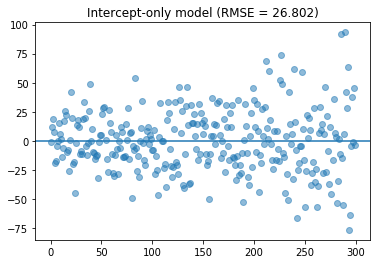

In [309]:
rmse = lambda y, yhat: np.sqrt(np.mean((y - yhat)**2))

plt.scatter(range(N), y-yhat, alpha=0.5)
plt.axhline(y = 0)
plt.title("Intercept-only model (RMSE = {:.3f})".format(rmse(y, yhat)))
plt.show()

This plots supports my thinking here - we've recovered the mean nicely, but the errors are outrageous. You can also see the increasing variance which I programmed into this. 

Let's extend this model to include the covariates from which we simulated. If this works as expected, we should be able to recover the `ground_truth_betas` values that we used for simulation:

In [370]:
weights, yhat_regression, is_converged, num_iter = tfp.glm.fit(
  model_matrix = X,
  response = y,
  model = tfp.glm.Normal()
)
print(weights)

for i in range(3):
  print("beta {} (ground truth, estimated) = ({:.3f}, {:.3f})".format(
      i, 
      np.array(ground_truth_betas[i])[0][0],
      weights.numpy()[i]
  ))

tf.Tensor([-3.34230116  2.76960783  5.06312396], shape=(3,), dtype=float64)
beta 0 (ground truth, estimated) = (-5.114, -3.342)
beta 1 (ground truth, estimated) = (3.053, 2.770)
beta 2 (ground truth, estimated) = (5.098, 5.063)


The estimates here look pretty good. They aren't bang on, but they aren't bad. Let's see what the residuals look like:

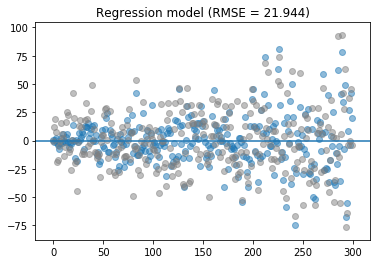

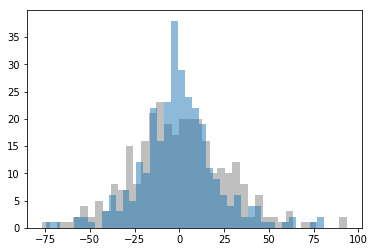

In [371]:
plt.scatter(range(N), y-yhat_regression, alpha=0.5)
plt.scatter(range(N), y-yhat, color='grey', alpha=0.5)
plt.axhline(y = 0)
plt.title("Regression model (RMSE = {:.3f})".format(rmse(y, yhat_regression)))
plt.show()

plt.hist(y - yhat, color='grey', alpha=0.5, bins=40)
plt.hist(y - yhat_regression, alpha=0.5, bins=40)
plt.show()

This is starting to look quite a bit better. The estimated coefficients are very close to the ground truth, the residuals are narrower than our intercept-only method and this has resulted in a good improvement in the RMSE.

Again, if we look at the residuals plot we can see the problems which arise from the heteroscedacity that we put into this data. In a fully-Bayesian framework, I should be able to also estimate the heteroscedasticity. However, I'm not sure that I can do this with this simple GLM api? Let's leave that as something to explore in the coming days.

For now, let's make some pretty plots for my LinkedIn posts :) 

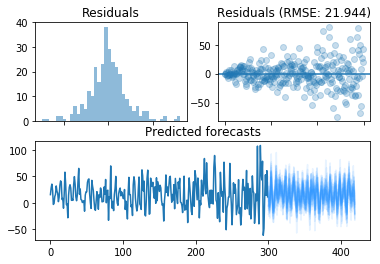

In [430]:
generative_model = tfd.Normal(loc = yhat_regression, scale = np.std(yhat_regression))

plt.figure(4)
plt.subplot(212)
plt.plot(range(N), y)
for x in range(20):
  plt.plot(range(N, N+120), generative_model.sample()[-120:], alpha=0.1, color='dodgerblue')
plt.title("Predicted forecasts")

plt.subplot(222)
plt.scatter(range(N), y-yhat_regression, alpha=0.25)
plt.axhline(y = 0)
ax = plt.gca()
ax.set_xticklabels([])
plt.title("Residuals (RMSE: {:.3f})".format(rmse(y, yhat_regression)))

plt.subplot(221)
plt.hist(y - yhat_regression, alpha=0.5, bins=40)
ax = plt.gca()
ax.set_xticklabels([])
plt.title("Residuals")


plt.show()

Ovearall this is pretty good. The seasonality has been captured and the predictions are within a reasonable range. My simulation here probably isn't perfect... I suspect that there is something not quite right about defining my `generative_model` the way I have done here. But let's worry about that another day.

### Future Efforts:  

This works still needs some tidying. How do I estimate the variance as well as the effects? How do I simulate new data properly? How do I get a better sense of the uncertainties? 

All work for the future.